In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

In [4]:
# Import the fourier method
from statsmodels.nonparametric.smoothers_lowess import lowess

# Define the four model variations

In [5]:
model_1_cube = FBRestNet(
    model_id = 'model_1_cube_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(2000,50,1,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=0.1, 
    nb_epochs=130,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=False
    )

In [6]:
model_1_cube.model.load_state_dict(torch.load(model_1_cube.model_folder+model_1_cube.model_id+'weights.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
# Create the gaussian signal
t     = np.linspace(0,1,model_1_cube.physics.nx)
gauss = np.exp(-(t-0.5)**2/(0.1)**(2))
# filtering high frequencies
gauss         = model_1_cube.physics.BasisChange(gauss)
gauss         = model_1_cube.physics.BasisChangeInv(gauss)
gauss[gauss<0] = 0
gauss = 0.9*(gauss+0.0)/np.amax(gauss)


In [8]:
# transform
x_blurred  = model_1_cube.physics.Compute(gauss).squeeze()
# Add noise 
noise = np.random.randn(model_1_cube.physics.nx)
x_blurred_n = x_blurred + model_1_cube.noise*np.linalg.norm(x_blurred)/np.sqrt(model_1_cube.physics.nx)*noise
# Create bias term
x_b = model_1_cube.physics.ComputeAdjoint(x_blurred_n)

## Model prediction

In [9]:
x_bias    = Variable(torch.FloatTensor(x_b.reshape(1,1,-1)),requires_grad=False)
x_init   = torch.zeros(x_bias.shape)
tTTinv   = MyMatmul(np.diag(model_1_cube.physics.eigm**(2*model_1_cube.physics.a)))
x_init   = tTTinv(x_bias) # filtration of high frequences
x_init   = Variable(x_init.reshape(1,1,-1),requires_grad=False)
# prediction
x_pred   = model_1_cube.model(x_init,x_bias)
xp_eig      = x_pred.detach().numpy()[0,0,:]
xp_elt       = model_1_cube.physics.BasisChangeInv(xp_eig)

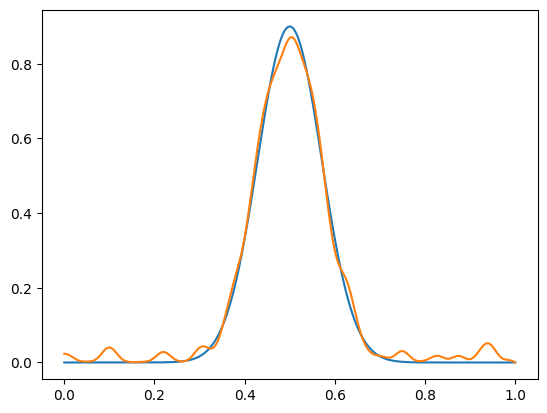

In [10]:
plt.plot(t,gauss)
plt.plot(t,xp_elt)

## Fourier Method

In [11]:
cut = 11/50
n_cut = int(model_1_cube.physics.m*cut)
filter = np.zeros((model_1_cube.physics.m,model_1_cube.physics.m))
np.fill_diagonal(filter[:n_cut,:n_cut], 1)

x_recovered = model_1_cube.physics.inv.dot(x_b)
# Filter the signal
x_filtered = filter.dot(x_recovered)
# Change to the continuous functions basis
x_filtered_elt = model_1_cube.physics.BasisChangeInv(x_filtered)

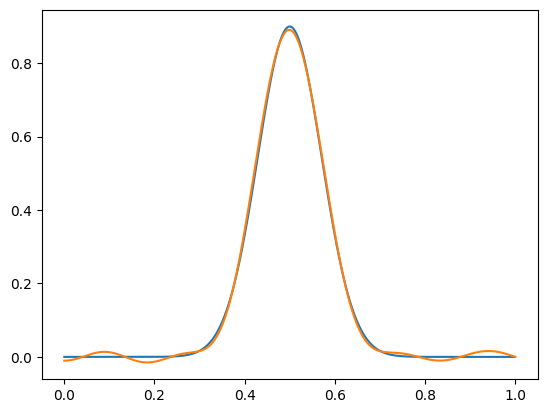

In [12]:
plt.plot(t,gauss)
plt.plot(t,x_filtered_elt)

## Lowess Method

In [13]:
# Recover the signal
x_recovered = model_1_cube.physics.inv.dot(x_b)
x_recover_noisy_elt = model_1_cube.physics.BasisChangeInv(x_recovered)
# Filter the signal
filtered = lowess(x_recover_noisy_elt, np.linspace(0,model_1_cube.physics.nx-1,model_1_cube.physics.nx),
    frac=150/2000,
    it=1,
    delta=10)
# Project signal into eigenfunction space
x_recovered_lowess = model_1_cube.physics.BasisChangeInv(model_1_cube.physics.BasisChange(filtered[:, 1]))

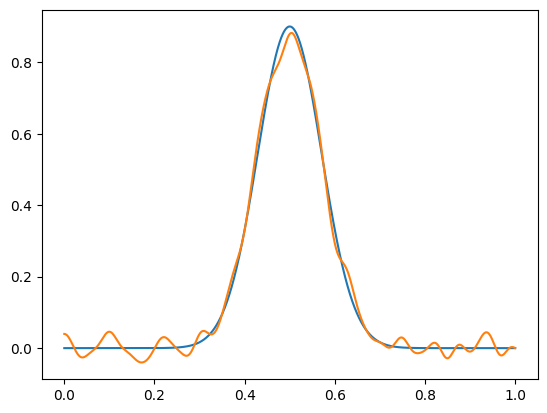

In [14]:
plt.plot(t,gauss)
plt.plot(t,x_recovered_lowess)

### Figure 10

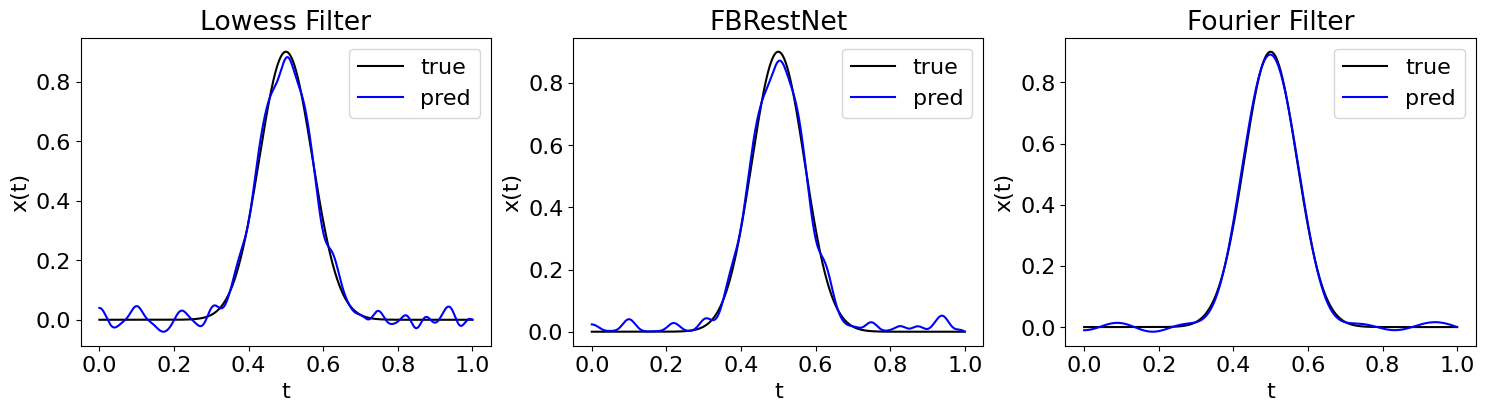

In [16]:
mpl.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,3,figsize=(18,4))

ax[0].plot(t,gauss,'k', label='true')
ax[0].plot(t,x_recovered_lowess, 'b', label='pred')
ax[0].set_title('Lowess Filter')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x(t)')
ax[0].legend()

ax[1].plot(t,gauss,'k', label='true')
ax[1].plot(t,xp_elt, 'b', label='pred')
ax[1].set_title('FBRestNet')
ax[1].set_xlabel('t')
ax[1].set_ylabel('x(t)')
ax[1].legend()

ax[2].plot(t,gauss,'k', label='true')
ax[2].plot(t,x_filtered_elt, 'b', label='pred')
ax[2].set_title('Fourier Filter')
ax[2].set_xlabel('t')
ax[2].set_ylabel('x(t)')
ax[2].legend()

plt.savefig('../Figures/Figure_gaussian_other_bigfont.pdf')
plt.show()